# **Laboratorio 04  SIS421**

### Nombre: Quispe Sucullani Jose David

### C.U. 111-376

### Link github:

##Contexto del Laboratorio


In [21]:
import torch
import torchvision
import os
from torch.utils.data import Dataset
from torchvision import datasets, transforms
import random
import matplotlib.pyplot as plt
from collections import Counter

import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

##1: Lectura del Dataset

In [22]:
# Definir las transformaciones para las imágenes
from torchvision import datasets, transforms
import torch.utils.data

# Definir las transformaciones para el conjunto de datos FashionMNIST
transform = transforms.Compose([
    transforms.Resize((28, 28)),  # Redimensionar las imágenes a 28x28 píxeles para FashionMNIST
    transforms.ToTensor(),  # Convertir las imágenes a tensores
    transforms.Normalize([0.5], [0.5])  # Normalizar entre [-1, 1] para las imágenes en escala de grises
])

# Cargar el conjunto de datos de entrenamiento y prueba de FashionMNIST con las transformaciones
train_data = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_data = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# Mostrar la cantidad de imágenes de entrenamiento y prueba
print(f"Número de imágenes de entrenamiento: {len(train_data)}")
print(f"Número de imágenes de prueba: {len(test_data)}")

Número de imágenes de entrenamiento: 60000
Número de imágenes de prueba: 10000


In [23]:
# Function to handle dataset limiting (not needed for FashionMNIST, so keeping it as is but it won't be used directly)
def limit_dataset_size(root_dir, max_per_class=6000):
    # Dictionary to store paths of selected images by class
    limited_dataset = []

    # Iterate through subfolders in root_dir (each subfolder is a class)
    for class_name in os.listdir(root_dir):
        class_dir = os.path.join(root_dir, class_name)
        if os.path.isdir(class_dir):
            # Get all images in the subfolder
            all_images = os.listdir(class_dir)
            # Filter to get only images, excluding other file types
            all_images = [os.path.join(class_name, img) for img in all_images if img.endswith(('.png', '.jpg', '.jpeg'))]
            # Randomly select 6000 images
            selected_images = random.sample(all_images, min(len(all_images), max_per_class))
            limited_dataset.extend(selected_images)

    return limited_dataset

In [24]:
# For FashionMNIST, we don't need a custom dataset class to limit size.
# The train_data loaded in the previous cell is already the full dataset.

# Verify the number of images in the training set (already done in the previous cell)
print(f"Número total de imágenes en el nuevo conjunto de entrenamiento: {len(train_data)}")

# Verify the number of images per class (FashionMNIST is balanced)
from collections import Counter
# Get the targets from the train_data object
class_distribution = Counter(train_data.targets.tolist())
print("Distribución de imágenes por clase:", class_distribution)

Número total de imágenes en el nuevo conjunto de entrenamiento: 60000
Distribución de imágenes por clase: Counter({9: 6000, 0: 6000, 3: 6000, 2: 6000, 7: 6000, 5: 6000, 1: 6000, 6: 6000, 4: 6000, 8: 6000})


In [25]:
# 1. Ver las etiquetas del dataset (clases):
# Ver las classes del dataset (etiquetas) for FashionMNIST
print(f"Clases en el conjunto de entrenamiento: {train_data.classes}")
print(f"Cantidad de clases: {len(train_data.classes)}")

Clases en el conjunto de entrenamiento: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
Cantidad de clases: 10


In [26]:
import torch
from collections import Counter

# Verify the total number of images in the training set
num_total_images = len(train_data)
print(f"Número total de imágenes en el conjunto de entrenamiento: {num_total_images}")

# Verify the number of classes (labels) for FashionMNIST
num_classes = len(train_data.classes)
print(f"Número de clases: {num_classes}")

# Get the labels of all images (train_data.targets has the labels for each image)
class_distribution = Counter(train_data.targets.tolist())

# Show how many images are in each class
for class_idx, count in class_distribution.items():
    print(f"Clase '{train_data.classes[class_idx]}' tiene {count} imágenes")

Número total de imágenes en el conjunto de entrenamiento: 60000
Número de clases: 10
Clase 'Ankle boot' tiene 6000 imágenes
Clase 'T-shirt/top' tiene 6000 imágenes
Clase 'Dress' tiene 6000 imágenes
Clase 'Pullover' tiene 6000 imágenes
Clase 'Sneaker' tiene 6000 imágenes
Clase 'Sandal' tiene 6000 imágenes
Clase 'Trouser' tiene 6000 imágenes
Clase 'Shirt' tiene 6000 imágenes
Clase 'Coat' tiene 6000 imágenes
Clase 'Bag' tiene 6000 imágenes


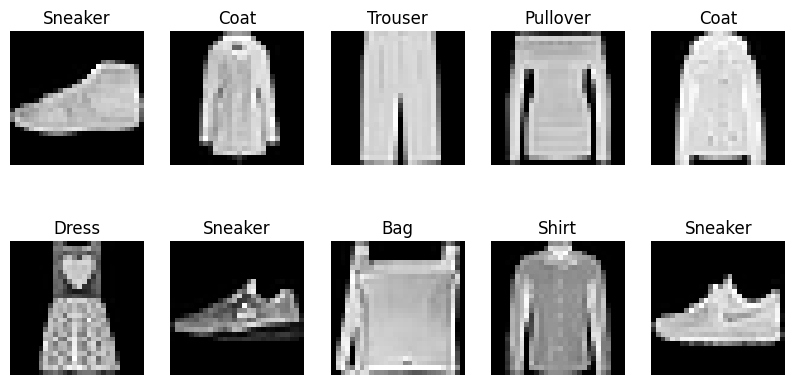

In [27]:
import random
import matplotlib.pyplot as plt
import numpy as np

# Get the classes from the dataset
classes = train_data.classes

# Convert images and labels to numpy arrays for easier processing
def imshow(img):
    img = img / 2 + 0.5     # Desnormalize
    npimg = img.numpy()
    # FashionMNIST is grayscale, so we handle it differently
    if npimg.shape[0] == 1:
        npimg = np.transpose(npimg, (1, 2, 0))[:, :, 0] # Remove the single channel dimension
    else:
        npimg = np.transpose(npimg, (1, 2, 0))
    return npimg

# Show 10 random images
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    index = random.randint(0, len(train_data) - 1)
    img, label = train_data[index]
    plt.imshow(imshow(img), cmap='gray') # Use gray colormap for grayscale images
    plt.title(classes[label])
    plt.axis('off')

plt.show()

El dataset está formado por 6000 imágenes de baja resolución (50 x 50 píxeles, con tres canales de colores) y contiene 10 tipos prentas

In [28]:
# Define a custom class for the dataset that normalizes to [-1, 1] (already handled by transform)
# We can just use the loaded train_data directly with the DataLoader
class Prendas(torch.utils.data.Dataset):
    def __init__(self, dataset):
        self.imgs = torch.stack([img[0] for img in dataset])  # Load images as tensors
        # Normalization to [-1, 1] is done in the transform
        self.labels = torch.tensor([img[1] for img in dataset], dtype=torch.long)  # Image labels

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        return self.imgs[idx], self.labels[idx]

In [29]:
# We don't need to create a separate normalized dataset class for FashionMNIST
# The normalization is done in the transform when loading the data.
# We will use the original 'train_data' with the DataLoader.
train_dataset = train_data

In [30]:
# Split images into batches
dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

#**MODELO DCGANs**

2. Definir el Generador (Generator)
Ahora, ajustamos el generador para manejar imágenes a color (3 canales) de tamaño 50x50

In [31]:
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.input_size = 100  # Size of the random input vector (latent vector)

        self.inp = nn.Sequential(
            nn.Linear(self.input_size, 7*7*256),  # Transform the input vector to a 7x7x256 feature map for 28x28 output
            nn.BatchNorm1d(7*7*256),  # Batch normalization for stable training
            nn.ReLU(True)
        )

        self.main = nn.Sequential(
            # First deconvolutional layer: 7x7x256 -> 14x14x128
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            # Second deconvolutional layer: 14x14x128 -> 28x28x64
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            # Third deconvolutional layer: 28x28x64 -> 28x28x1 (Grayscale)
            nn.ConvTranspose2d(64, 1, 3, stride=1, padding=1, bias=False), # Adjusted kernel size and stride for 28x28 output
            nn.Tanh()  # Normalize the output to a [-1, 1] range
        )

    def forward(self, x):
        x = self.inp(x)
        x = x.view(-1, 256, 7, 7)  # Reshape for 7x7 input with 256 channels
        x = self.main(x)
        return x

In [32]:
# Verify the output size
generator = Generator()
output = generator(torch.randn(64, 100))
print(output.shape)

torch.Size([64, 1, 28, 28])


###3. Definir el Discriminador (Discriminator)
Modificamos el discriminador para aceptar imágenes a color de tamaño 50x50:

In [33]:
import torch
import torch.nn as nn

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            # First convolutional layer: 28x28x1 -> 14x14x64
            nn.Conv2d(1, 64, 4, stride=2, padding=1, bias=False), # Input channels changed to 1
            nn.LeakyReLU(0.2, inplace=True),

            # Second convolutional layer: 14x14x64 -> 7x7x128
            nn.Conv2d(64, 128, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            # Third convolutional layer: 7x7x128 -> 4x4x256
            nn.Conv2d(128, 256, 3, stride=2, padding=1, bias=False), # Adjusted kernel size
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            # Fourth convolutional layer: 4x4x256 -> 2x2x512 (or similar depending on padding/stride)
            # Let's adjust the last conv layer for 4x4 to 1x1 output
            nn.Conv2d(256, 512, 4, stride=1, padding=0, bias=False), # Adjusted kernel size and padding for 1x1 output
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True)
        )

        self.out = nn.Sequential(
            # Linear layer for classification
            nn.Linear(512*1*1, 1),  # Flatten the output tensor from the convolutional layer (now 1x1x512)
            nn.Sigmoid()  # Output between 0 and 1
        )

    def forward(self, x):
        x = self.main(x)  # Pass the input through the convolutional layers
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.out(x)  # Pass through the final linear layer
        return x

In [34]:
discriminator = Discriminator()
# Adjust the input size to match FashionMNIST images (grayscale 28x28)
output = discriminator(torch.randn(64, 1, 28, 28))
print(output.shape)

torch.Size([64, 1])


###4. Definimos el Proceso de Entrenamiento
Configuramos el bucle de entrenamiento, la función de pérdida y los optimizadores:

In [35]:
from fastprogress import master_bar, progress_bar
import numpy as np
import os

def fit(g, d, dataloader, epochs=25, crit=None, checkpoint_dir='/content/drive/MyDrive/SIS421-IA2/Laboratorios/LAB-04/', save_interval=5):
    g.to(device)
    d.to(device)

    g_optimizer = torch.optim.Adam(g.parameters(), lr=3e-4)
    d_optimizer = torch.optim.Adam(d.parameters(), lr=3e-4)

    crit = nn.BCEWithLogitsLoss() if crit is None else crit

    g_loss, d_loss = [], []
    mb = master_bar(range(1, epochs+1))
    hist = {'g_loss': [], 'd_loss': []}

    # Create the checkpoint directory if it doesn't exist
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)

    for epoch in mb:
        for X, _ in progress_bar(dataloader, parent=mb):
            X = X.to(device)  # Ensure real images go to the device

            # Train the discriminator
            g.eval()
            d.train()

            # Generate a batch of fake images
            noise = torch.randn((X.size(0), g.input_size)).to(device)  # Noise vector
            generated_images = g(noise)  # Generate fake images

            # Concatenate real and generated images for the discriminator
            d_input = torch.cat([generated_images, X], dim=0)
            # Create labels: 0 for fake images and 1 for real images
            d_gt = torch.cat([torch.zeros(X.size(0)), torch.ones(X.size(0))]).view(-1, 1).to(device)

            # Optimize the discriminator
            d_optimizer.zero_grad()
            d_output = d(d_input)
            d_l = crit(d_output, d_gt)
            d_l.backward()
            d_optimizer.step()
            d_loss.append(d_l.item())

            # Train the generator
            g.train()
            d.eval()

            # Generate a new batch of fake images
            noise = torch.randn((X.size(0), g.input_size)).to(device)
            generated_images = g(noise)

            # Pass the fake images through the discriminator
            d_output = d(generated_images)
            # Generator's goal: fool the discriminator, so we use "real" labels (1)
            g_gt = torch.ones(X.size(0)).view(-1, 1).to(device)

            # Optimize the generator
            g_optimizer.zero_grad()
            g_l = crit(d_output, g_gt)
            g_l.backward()
            g_optimizer.step()
            g_loss.append(g_l.item())

            # Progress logs
            mb.child.comment = f'g_loss {np.mean(g_loss):.5f} d_loss {np.mean(d_loss):.5f}'
        mb.write(f'Epoch {epoch}/{epochs} g_loss {np.mean(g_loss):.5f} d_loss {np.mean(d_loss):.5f}')
        hist['g_loss'].append(np.mean(g_loss))
        hist['d_loss'].append(np.mean(d_loss))


        # Save a checkpoint every 'save_interval' epochs
        if epoch % save_interval == 0:
            torch.save({
                'epoch': epoch,
                'generator_state_dict': g.state_dict(),
                'discriminator_state_dict': d.state_dict(),
                'g_optimizer_state_dict': g_optimizer.state_dict(),
                'd_optimizer_state_dict': d_loss
            }, os.path.join(checkpoint_dir, f'GANs_modelo_{epoch}.pth'))

    return hist

In [36]:
# Ejecuta el entrenamiento
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
hist = fit(generator, discriminator, dataloader, crit=torch.nn.BCELoss())

## CONTINUANDO CON EL ENTRENAMIENTO

In [37]:
from fastprogress import master_bar, progress_bar

def load_checkpoint(checkpoint_path, g, d, g_optimizer, d_optimizer):
    checkpoint = torch.load(checkpoint_path)
    g.load_state_dict(checkpoint['generator_state_dict'])
    d.load_state_dict(checkpoint['discriminator_state_dict'])
    g_optimizer.load_state_dict(checkpoint['g_optimizer_state_dict'])
    d_optimizer.load_state_dict(checkpoint['d_optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1  # Reanudar desde el siguiente epoch
    g_loss = checkpoint['g_loss']
    d_loss = checkpoint['d_loss']
    return start_epoch, g_loss, d_loss


In [42]:
# Celda 3: Definición de la función fit (incluye load_checkpoint)
# Reemplaza la definición existente de fit con este código
def fit(g, d, dataloader, epochs=25, crit=None, checkpoint_dir='/content/drive/MyDrive/SIS421-IA2/Laboratorios/LAB-04/', save_interval=5, resume_from_checkpoint=None):
    g.to(device)
    d.to(device)

    g_optimizer = torch.optim.Adam(g.parameters(), lr=3e-4)
    d_optimizer = torch.optim.Adam(d.parameters(), lr=3e-4)

    crit = nn.BCEWithLogitsLoss() if crit is None else crit

    # Helper function to load checkpoint (defined inside fit to ensure correct version is used)
    def load_checkpoint(checkpoint_path, g, d, g_optimizer, d_optimizer):
        checkpoint = torch.load(checkpoint_path)
        g.load_state_dict(checkpoint['generator_state_dict'])
        d.load_state_dict(checkpoint['discriminator_state_dict'])
        g_optimizer.load_state_dict(checkpoint['g_optimizer_state_dict'])
        d_optimizer.load_state_dict(checkpoint['d_optimizer_state_dict'])
        start_epoch = checkpoint['epoch'] + 1
        g_loss = checkpoint.get('g_loss', [])
        d_loss = checkpoint.get('d_loss', [])
        print(f"Checkpoint loaded from epoch {checkpoint.get('epoch', 'N/A')}")
        return start_epoch, g_loss, d_loss


    if resume_from_checkpoint:
        try:
            start_epoch, g_loss, d_loss = load_checkpoint(resume_from_checkpoint, g, d, g_optimizer, d_optimizer)
            print(f"Resuming training from epoch {start_epoch}")
        except Exception as e:
            print(f"Error loading checkpoint: {e}")
            print("Starting training from scratch instead.")
            start_epoch = 1
            g_loss, d_loss = [], []
    else:
        start_epoch = 1
        g_loss, d_loss = [], []

    mb = master_bar(range(start_epoch, epochs+1))
    hist = {'g_loss': g_loss, 'd_loss': d_loss}


    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)

    for epoch in mb:
        current_epoch_g_loss = []
        current_epoch_d_loss = []

        for X, _ in progress_bar(dataloader, parent=mb):
            X = X.to(device)

            g.eval()
            d.train()

            noise = torch.randn((X.size(0), g.input_size)).to(device)
            generated_images = g(noise)

            d_input = torch.cat([generated_images, X], dim=0)
            d_gt = torch.cat([torch.zeros(X.size(0)), torch.ones(X.size(0))]).view(-1, 1).to(device)

            d_optimizer.zero_grad()
            d_output = d(d_input)
            d_l = crit(d_output, d_gt)
            d_l.backward()
            d_optimizer.step()
            current_epoch_d_loss.append(d_l.item())


            g.train()
            d.eval()

            noise = torch.randn((X.size(0), g.input_size)).to(device)
            generated_images = g(noise)

            d_output = d(generated_images)
            g_gt = torch.ones(X.size(0)).view(-1, 1).to(device)

            g_optimizer.zero_grad()
            g_l = crit(d_output, g_gt)
            g_l.backward()
            g_optimizer.step()
            current_epoch_g_loss.append(g_l.item())

            mb.child.comment = f'g_loss {np.mean(current_epoch_g_loss):.5f} d_loss {np.mean(current_epoch_d_loss):.5f}'

        hist['g_loss'].append(np.mean(current_epoch_g_loss))
        hist['d_loss'].append(np.mean(current_epoch_d_loss))

        mb.write(f'Epoch {epoch}/{epochs} g_loss {hist["g_loss"][-1]:.5f} d_loss {hist["d_loss"][-1]:.5f}')


        if epoch % save_interval == 0:
            torch.save({
                'epoch': epoch,
                'generator_state_dict': g.state_dict(),
                'discriminator_state_dict': d.state_dict(),
                'g_optimizer_state_dict': g_optimizer.state_dict(),
                'd_optimizer_state_dict': d_optimizer.state_dict(),
                'g_loss': hist['g_loss'],
                'd_loss': hist['d_loss']
            }, os.path.join(checkpoint_dir, f'GANs_modelo_{epoch}.pth'))

    return hist

In [43]:
# Ejecutar el entrenamiento desde el último checkpoint
checkpoint_path = '/content/drive/MyDrive/SIS421-IA2/Laboratorios/LAB-04/GANs_modelo_25.pth'  # Cambia esto por tu último checkpoint guardado
hist = fit(generator, discriminator, dataloader, crit=torch.nn.BCELoss(), resume_from_checkpoint=checkpoint_path)

Error loading checkpoint: Weights only load failed. This file can still be loaded, to do so you have two options, do those steps only if you trust the source of the checkpoint. 
	(1) In PyTorch 2.6, we changed the default value of the `weights_only` argument in `torch.load` from `False` to `True`. Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution. Do it only if you got the file from a trusted source.
	(2) Alternatively, to load with `weights_only=True` please check the recommended steps in the following error message.
	WeightsUnpickler error: Unsupported global: GLOBAL numpy._core.multiarray.scalar was not an allowed global by default. Please use `torch.serialization.add_safe_globals([numpy._core.multiarray.scalar])` or the `torch.serialization.safe_globals([numpy._core.multiarray.scalar])` context manager to allowlist this global if you trust this class/function.

Check the documentation of torch.load to learn

In [44]:
 from fastprogress import master_bar, progress_bar
import numpy as np
import os

def load_checkpoint(checkpoint_path, g, d, g_optimizer, d_optimizer):
    checkpoint = torch.load(checkpoint_path)
    g.load_state_dict(checkpoint['generator_state_dict'])
    d.load_state_dict(checkpoint['discriminator_state_dict'])
    g_optimizer.load_state_dict(checkpoint['g_optimizer_state_dict'])
    # Corrected: Load the discriminator optimizer state dictionary
    d_optimizer.load_state_dict(checkpoint['d_optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1  # Resume from the next epoch
    g_loss = checkpoint['g_loss']
    d_loss = checkpoint['d_loss']
    return start_epoch, g_loss, d_loss

def fit(g, d, dataloader, epochs=25, crit=None, checkpoint_dir='/content/drive/MyDrive/SIS421-IA2/Laboratorios/LAB-04/', save_interval=5, resume_from_checkpoint=None):
    g.to(device)
    d.to(device)

    g_optimizer = torch.optim.Adam(g.parameters(), lr=3e-4)
    d_optimizer = torch.optim.Adam(d.parameters(), lr=3e-4)

    crit = nn.BCEWithLitLoss() if crit is None else crit

    # If resuming from a checkpoint, load the model, optimizers, and losses
    if resume_from_checkpoint:
        start_epoch, g_loss, d_loss = load_checkpoint(resume_from_checkpoint, g, d, g_optimizer, d_optimizer)
    else:
        start_epoch = 1
        g_loss, d_loss = [], []

    mb = master_bar(range(start_epoch, epochs+1))
    hist = {'g_loss': [], 'd_loss': []}

    # Create the checkpoint directory if it doesn't exist
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)

    for epoch in mb:
        for X, _ in progress_bar(dataloader, parent=mb):
            X = X.to(device)  # Ensure real images go to the device

            # Train the discriminator
            g.eval()
            d.train()

            # Generate a batch of fake images
            noise = torch.randn((X.size(0), g.input_size)).to(device)  # Noise vector
            generated_images = g(noise)  # Generate fake images

            # Concatenate real and generated images for the discriminator
            d_input = torch.cat([generated_images, X], dim=0)
            # Create labels: 0 for fake images and 1 for real images
            d_gt = torch.cat([torch.zeros(X.size(0)), torch.ones(X.size(0))]).view(-1, 1).to(device)

            # Optimize the discriminator
            d_optimizer.zero_grad()
            d_output = d(d_input)
            d_l = crit(d_output, d_gt)
            d_l.backward()
            d_optimizer.step()
            d_loss.append(d_l.item())

            # Train the generator
            g.train()
            d.eval()

            # Generate a new batch of fake images
            noise = torch.randn((X.size(0), g.input_size)).to(device)
            generated_images = g(noise)

            # Pass the fake images through the discriminator
            d_output = d(generated_images)
            # Generator's goal: fool the discriminator, so we use "real" labels (1)
            g_gt = torch.ones(X.size(0)).view(-1, 1).to(device)

            # Optimize the generator
            g_optimizer.zero_grad()
            g_l = crit(d_output, g_gt)
            g_l.backward()
            g_optimizer.step()
            g_loss.append(g_l.item())

            # Progress logs
            mb.child.comment = f'g_loss {np.mean(g_loss):.5f} d_loss {np.mean(d_loss):.5f}'
        mb.write(f'Epoch {epoch}/{epochs} g_loss {np.mean(g_loss):.5f} d_loss {np.mean(d_loss):.5f}')
        hist['g_loss'].append(np.mean(g_loss))
        hist['d_loss'].append(np.mean(d_loss))

        # Save a checkpoint every 'save_interval' epochs
        if epoch % save_interval == 0:
            torch.save({
                'epoch': epoch,
                'generator_state_dict': g.state_dict(),
                'discriminator_state_dict': d.state_dict(),
                'g_optimizer_state_dict': g_optimizer.state_dict(),
                'd_optimizer_state_dict': d_optimizer.state_dict(), # Corrected: Save the discriminator optimizer state dict
                'g_loss': g_loss,
                'd_loss': d_loss
            }, os.path.join(checkpoint_dir, f'GANs_modelo_{epoch}.pth'))

    return hist

In [45]:
def fit(g, d, dataloader, epochs=25, crit=None, checkpoint_dir='/content/drive/MyDrive/SIS421-IA2/Laboratorios/LAB-04', save_interval=5, resume_from_checkpoint=None):
    g.to(device)
    d.to(device)

    g_optimizer = torch.optim.Adam(g.parameters(), lr=3e-4)
    d_optimizer = torch.optim.Adam(d.parameters(), lr=3e-4)

    crit = nn.BCEWithLogitsLoss() if crit is None else crit

    # Si se retoma desde un checkpoint, cargar el modelo, optimizadores y pérdidas
    if resume_from_checkpoint:
        start_epoch, g_loss, d_loss = load_checkpoint(resume_from_checkpoint, g, d, g_optimizer, d_optimizer)
    else:
        start_epoch = 1
        g_loss, d_loss = [], []

    mb = master_bar(range(start_epoch, epochs+1))
    hist = {'g_loss': [], 'd_loss': []}

    # Crear el directorio de checkpoints si no existe
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)

    for epoch in mb:
        for X, _ in progress_bar(dataloader, parent=mb):
            X = X.to(device)  # Aseguramos que las imágenes reales vayan al dispositivo

            # Entrenamos el discriminador
            g.eval()
            d.train()

            # Generamos un batch de imágenes falsas
            noise = torch.randn((X.size(0), g.input_size)).to(device)  # Vector de ruido
            generated_images = g(noise)  # Generamos imágenes falsas

            # Concatenamos imágenes reales y generadas para el discriminador
            d_input = torch.cat([generated_images, X], dim=0)
            # Creamos etiquetas: 0 para imágenes falsas y 1 para reales
            d_gt = torch.cat([torch.zeros(X.size(0)), torch.ones(X.size(0))]).view(-1, 1).to(device)

            # Optimizamos el discriminador
            d_optimizer.zero_grad()
            d_output = d(d_input)
            d_l = crit(d_output, d_gt)
            d_l.backward()
            d_optimizer.step()
            d_loss.append(d_l.item())

            # Entrenamos el generador
            g.train()
            d.eval()

            # Generamos un nuevo batch de imágenes falsas
            noise = torch.randn((X.size(0), g.input_size)).to(device)
            generated_images = g(noise)

            # Pasamos las imágenes falsas por el discriminador
            d_output = d(generated_images)
            # Objetivo del generador: engañar al discriminador, por eso usamos etiquetas de "reales" (1)
            g_gt = torch.ones(X.size(0)).view(-1, 1).to(device)

            # Optimizamos el generador
            g_optimizer.zero_grad()
            g_l = crit(d_output, g_gt)
            g_l.backward()
            g_optimizer.step()
            g_loss.append(g_l.item())

            # Logs de progreso
            mb.child.comment = f'g_loss {np.mean(g_loss):.5f} d_loss {np.mean(d_loss):.5f}'
        mb.write(f'Epoch {epoch}/{epochs} g_loss {np.mean(g_loss):.5f} d_loss {np.mean(d_loss):.5f}')
        hist['g_loss'].append(np.mean(g_loss))
        hist['d_loss'].append(np.mean(d_loss))

        # Guardar un checkpoint cada 'save_interval' épocas
        if epoch % save_interval == 0:
            torch.save({
                'epoch': epoch,
                'generator_state_dict': g.state_dict(),
                'discriminator_state_dict': d.state_dict(),
                'g_optimizer_state_dict': g_optimizer.state_dict(),
                'd_optimizer_state_dict': d_optimizer.state_dict(),
                'g_loss': g_loss,
                'd_loss': d_loss
            }, os.path.join(checkpoint_dir, f'GANs_modelo_{epoch}.pth'))

    return hist

##EVALUACIÓN DE LOS MODELOS

###Cargamos los modelos guardados para verificar el mejor medelo.

In [46]:
import torch

# Cargar un model dado
def load_model(checkpoint_path, g, d, g_optimizer, d_optimizer):
    # Added weights_only=False to allow loading of the checkpoint
    model = torch.load(checkpoint_path, weights_only=False)
    g.load_state_dict(model['generator_state_dict'])
    d.load_state_dict(model['discriminator_state_dict'])
    g_optimizer.load_state_dict(model['g_optimizer_state_dict'])
    d_optimizer.load_state_dict(model['d_optimizer_state_dict'])
    epoch = model['epoch']
    g_loss = model['g_loss']
    d_loss = model['d_loss']
    print(f"Checkpoint loaded from epoch {epoch}")
    return epoch, g_loss, d_loss

In [47]:
import matplotlib.pyplot as plt
import torch

def generate_and_plot_images(g, num_images=5):
    g.eval()  # Evaluation mode
    noise = torch.randn(num_images, g.input_size).to(device)
    with torch.no_grad():
        generated_images = g(noise).cpu()

    # Show the generated images
    fig, axs = plt.subplots(1, num_images, figsize=(num_images * 3, 3))
    for i in range(num_images):
        img = generated_images[i].squeeze().permute(1, 0)  # Remove channel dimension for grayscale
        img = (img + 1) / 2  # Desnormalize if using [-1, 1]
        axs[i].imshow(img, cmap='gray') # Use gray colormap
        axs[i].axis('off')
    plt.show()

Cargamos los modelos para ver los mejores valores resultados


Cargando y evaluando: /content/drive/MyDrive/SIS421-IA2/Laboratorios/LAB-04/GANs_modelo_20.pth
Checkpoint loaded from epoch 20
Evaluando el checkpoint del epoch 20: Último g_loss = 5.11087, Último d_loss = 0.11405


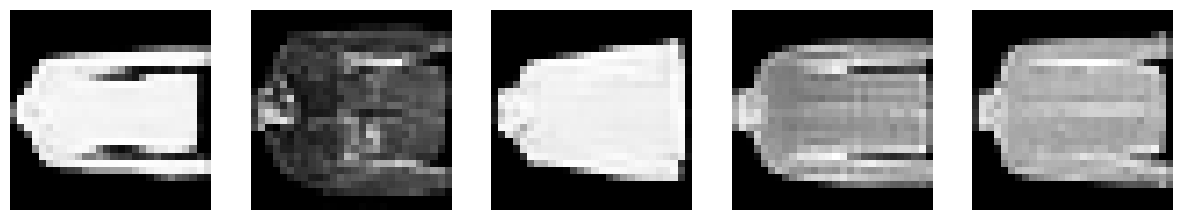


Cargando y evaluando: /content/drive/MyDrive/SIS421-IA2/Laboratorios/LAB-04/GANs_modelo_22.pth
Error: El archivo /content/drive/MyDrive/SIS421-IA2/Laboratorios/LAB-04/GANs_modelo_22.pth no fue encontrado.

Cargando y evaluando: /content/drive/MyDrive/SIS421-IA2/Laboratorios/LAB-04/GANs_modelo_24.pth
Error: El archivo /content/drive/MyDrive/SIS421-IA2/Laboratorios/LAB-04/GANs_modelo_24.pth no fue encontrado.


In [49]:
import torch
import torch.nn as nn
import torch.optim as optim
import os # Import the os module

# Asegúrate de que las definiciones de las clases Generator y Discriminator (en tus celdas anteriores)
# se hayan ejecutado ANTES de esta celda.
# Por ejemplo:
# class Generator(nn.Module):
#     ... # Tu definición aquí
# class Discriminator(nn.Module):
#     ... # Tu definición aquí

# Inicializar el generador y discriminador
generator = Generator().to(device) # Asegúrate de enviarlos al dispositivo
discriminator = Discriminator().to(device) # Asegúrate de enviarlos al dispositivo

# Inicializar los optimizadores
# Aunque fit los inicializa internamente, load_model espera optimizadores ya creados
g_optimizer = optim.Adam(generator.parameters(), lr=3e-4)
d_optimizer = optim.Adam(discriminator.parameters(), lr=3e-4)

models = [
    '/content/drive/MyDrive/SIS421-IA2/Laboratorios/LAB-04/GANs_modelo_20.pth',
    '/content/drive/MyDrive/SIS421-IA2/Laboratorios/LAB-04/GANs_modelo_22.pth',
    '/content/drive/MyDrive/SIS421-IA2/Laboratorios/LAB-04/GANs_modelo_24.pth'
]

# Asegúrate de que la función load_model (celda Wtz7GKT9U7J7)
# y generate_and_plot_images (celda gWleQc0AVfMT)
# se hayan ejecutado ANTES de este bucle.

for model in models:
    print(f"\nCargando y evaluando: {model}")
    # Check if the model file exists before attempting to load
    if os.path.exists(model):
        # Asegúrate de que la función load_model esté definida y ejecutada
        # La función load_model debe cargar el estado de los optimizadores también
        epoch, g_loss_hist, d_loss_hist = load_model(model, generator, discriminator, g_optimizer, d_optimizer)

        # Usamos las últimas pérdidas guardadas en el historial
        print(f"Evaluando el checkpoint del epoch {epoch}: Último g_loss = {g_loss_hist[-1]:.5f}, Último d_loss = {d_loss_hist[-1]:.5f}")

        # Asegúrate de que la función generate_and_plot_images esté definida y ejecutada
        generate_and_plot_images(generator, num_images=5)
    else:
        print(f"Error: El archivo {model} no fue encontrado.")

In [51]:
g_loss_total = []
d_loss_total = []

for model in models:
    # Check if the model file exists before attempting to load
    if os.path.exists(model):
        epoch, g_loss, d_loss = load_model(model, generator, discriminator, g_optimizer, d_optimizer)
        g_loss_total.extend(g_loss)  # Agregar las pérdidas del generador
        d_loss_total.extend(d_loss)  # Agregar las pérdidas del discriminador
    else:
        print(f"Warning: El archivo {model} no fue encontrado. Saltando este checkpoint.")

Checkpoint loaded from epoch 20


###5. Visualización de los Resultados
Al finalizar el entrenamiento, visualizamos las imágenes generadas:

In [53]:
# Ruta del modelo que deseas cargar
model_ = '/content/drive/MyDrive/SIS421-IA2/Laboratorios/LAB-04/GANs_modelo_25.pth'

# Función para cargar el modelo
epoch, g_loss, d_loss = load_model(model_, generator, discriminator, g_optimizer, d_optimizer)

# Imprimir información del modelo cargado
print(f"Checkpoint del epoch {epoch} cargado: g_loss = {g_loss[-1]}, d_loss = {d_loss[-1]}")


Checkpoint loaded from epoch 25
Checkpoint del epoch 25 cargado: g_loss = 5.302313361740112, d_loss = 0.10877061065832774


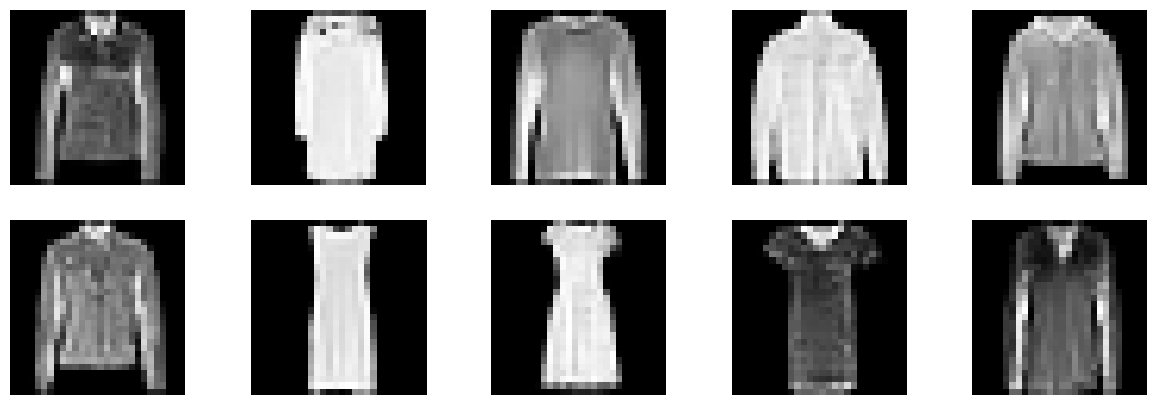

In [54]:
import matplotlib.pyplot as plt
import torch

# Put the generator in evaluation mode
generator.eval()

# Generate images without calculating gradients
with torch.no_grad():
    # Create random noise to generate 10 images
    noise = torch.randn((10, generator.input_size)).to(device)

    # Generate images from the noise
    generated_images = generator(noise)

    # Configure the figure to display the images
    fig, axs = plt.subplots(2, 5, figsize=(15, 5))
    i = 0

    # Iterate through each axis and display the images
    for ax_row in axs:
        for ax in ax_row:
            # Reorganize image channels for visualization (from [C, H, W] to [H, W, C] - not needed for grayscale)
            # Squeeze to remove the single channel dimension for grayscale images
            img = generated_images[i].squeeze().cpu()

            # Rescale image values from [-1, 1] to [0, 1] for visualization
            ax.imshow((img + 1) / 2, cmap='gray')  # Use gray colormap
            ax.axis('off')  # Hide axes
            i += 1

    # Show the generated images
    plt.show()

En este caso las imágenes generadas son un poco mejores que las que obteníamos con la GAN simple, aunque todavía hay márgen de mejora.

In [57]:
from fastprogress import master_bar, progress_bar
import numpy as np
import os
import torch
import torch.nn as nn

def load_checkpoint(checkpoint_path, g, d, g_optimizer, d_optimizer):
    # Added weights_only=False to allow loading of the checkpoint
    checkpoint = torch.load(checkpoint_path, weights_only=False)
    g.load_state_dict(checkpoint['generator_state_dict'])
    d.load_state_dict(checkpoint['discriminator_state_dict'])
    g_optimizer.load_state_dict(checkpoint['g_optimizer_state_dict'])
    d_optimizer.load_state_dict(checkpoint['d_optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1  # Resume from the next epoch
    g_loss = checkpoint['g_loss']
    d_loss = checkpoint['d_loss']
    return start_epoch, g_loss, d_loss

def fit(g, d, dataloader, epochs=25, crit=None, checkpoint_dir='/content/drive/MyDrive/SIS421-IA2/Laboratorios/LAB-04/', save_interval=5, resume_from_checkpoint=None):
    g.to(device)
    d.to(device)

    g_optimizer = torch.optim.Adam(g.parameters(), lr=3e-4)
    d_optimizer = torch.optim.Adam(d.parameters(), lr=3e-4)

    crit = nn.BCEWithLogitsLoss() if crit is None else crit

    # If resuming from a checkpoint, load the model, optimizers, and losses
    if resume_from_checkpoint:
        # Modified: Call the updated load_checkpoint function
        start_epoch, g_loss, d_loss = load_checkpoint(resume_from_checkpoint, g, d, g_optimizer, d_optimizer)
    else:
        start_epoch = 1
        g_loss, d_loss = [], []

    mb = master_bar(range(start_epoch, epochs+1))
    hist = {'g_loss': [], 'd_loss': []}

    # Create the checkpoint directory if it doesn't exist
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)

    for epoch in mb:
        for X, _ in progress_bar(dataloader, parent=mb):
            X = X.to(device)  # Ensure real images go to the device

            # Train the discriminator
            g.eval()
            d.train()

            # Generate a batch of fake images
            noise = torch.randn((X.size(0), g.input_size)).to(device)  # Noise vector
            generated_images = g(noise)  # Generate fake images

            # Concatenate real and generated images for the discriminator
            d_input = torch.cat([generated_images, X], dim=0)
            # Create labels: 0 for fake images and 1 for real images
            d_gt = torch.cat([torch.zeros(X.size(0)), torch.ones(X.size(0))]).view(-1, 1).to(device)

            # Optimize the discriminator
            d_optimizer.zero_grad()
            d_output = d(d_input)
            d_l = crit(d_output, d_gt)
            d_l.backward()
            d_optimizer.step()
            d_loss.append(d_l.item())

            # Train the generator
            g.train()
            d.eval()

            # Generate a new batch of fake images
            noise = torch.randn((X.size(0), g.input_size)).to(device)
            generated_images = g(noise)

            # Pass the fake images through the discriminator
            d_output = d(generated_images)
            # Generator's goal: fool the discriminator, so we use "real" labels (1)
            g_gt = torch.ones(X.size(0)).view(-1, 1).to(device)

            # Optimize the generator
            g_optimizer.zero_grad()
            g_l = crit(d_output, g_gt)
            g_l.backward()
            g_optimizer.step()
            g_loss.append(g_l.item())

            # Progress logs
            mb.child.comment = f'g_loss {np.mean(g_loss):.5f} d_loss {np.mean(d_loss):.5f}'
        mb.write(f'Epoch {epoch}/{epochs} g_loss {np.mean(g_loss):.5f} d_loss {np.mean(d_loss):.5f}')
        hist['g_loss'].append(np.mean(g_loss))
        hist['d_loss'].append(np.mean(d_loss))

        # Save a checkpoint every 'save_interval' epochs
        if epoch % save_interval == 0:
            torch.save({
                'epoch': epoch,
                'generator_state_dict': g.state_dict(),
                'discriminator_state_dict': d.state_dict(),
                'g_optimizer_state_dict': g_optimizer.state_dict(),
                'd_optimizer_state_dict': d_optimizer.state_dict(),
                'g_loss': g_loss,
                'd_loss': d_loss
            }, os.path.join(checkpoint_dir, f'GANs_modelo_{epoch}.pth'))

    return hist

In [58]:
# Ejecutar el entrenamiento desde el último checkpoint
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
checkpoint_path = '/content/drive/MyDrive/SIS421-IA2/Laboratorios/LAB-04/GANs_modelo_25.pth'  # Cambia esto por tu último checkpoint guardado
hist = fit(generator, discriminator, dataloader, crit=torch.nn.BCELoss(), resume_from_checkpoint=checkpoint_path)

In [59]:
from fastprogress import master_bar, progress_bar
import numpy as np
import os
import torch
import torch.nn as nn

def fit(g, d, dataloader, epochs=25, crit=None, checkpoint_dir='/content/drive/MyDrive/SIS421-IA2/Laboratorios/LAB-04/', save_interval=5, resume_from_checkpoint=None):
    g.to(device)
    d.to(device)

    g_optimizer = torch.optim.Adam(g.parameters(), lr=3e-4)
    d_optimizer = torch.optim.Adam(d.parameters(), lr=3e-4)

    crit = nn.BCEWithLogitsLoss() if crit is None else crit

    # Helper function to load checkpoint (defined inside fit to ensure correct version is used)
    def load_checkpoint(checkpoint_path, g, d, g_optimizer, d_optimizer):
        checkpoint = torch.load(checkpoint_path)
        g.load_state_dict(checkpoint['generator_state_dict'])
        d.load_state_dict(checkpoint['discriminator_state_dict'])
        g_optimizer.load_state_dict(checkpoint['g_optimizer_state_dict'])
        d_optimizer.load_state_dict(checkpoint['d_optimizer_state_dict'])
        start_epoch = checkpoint['epoch'] + 1  # Resume from the next epoch
        g_loss = checkpoint['g_loss']
        d_loss = checkpoint['d_loss']
        return start_epoch, g_loss, d_loss

    # If resuming from a checkpoint, load the model, optimizers, and losses
    if resume_from_checkpoint:
        start_epoch, g_loss, d_loss = load_checkpoint(resume_from_checkpoint, g, d, g_optimizer, d_optimizer)
    else:
        start_epoch = 1
        g_loss, d_loss = [], []

    mb = master_bar(range(start_epoch, epochs+1))
    hist = {'g_loss': [], 'd_loss': []}

    # Create the checkpoint directory if it doesn't exist
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)

    for epoch in mb:
        for X, _ in progress_bar(dataloader, parent=mb):
            X = X.to(device)  # Ensure real images go to the device

            # Train the discriminator
            g.eval()
            d.train()

            # Generate a batch of fake images
            noise = torch.randn((X.size(0), g.input_size)).to(device)  # Noise vector
            generated_images = g(noise)  # Generate fake images

            # Concatenate real and generated images for the discriminator
            d_input = torch.cat([generated_images, X], dim=0)
            # Create labels: 0 for fake images and 1 for real images
            d_gt = torch.cat([torch.zeros(X.size(0)), torch.ones(X.size(0))]).view(-1, 1).to(device)

            # Optimize the discriminator
            d_optimizer.zero_grad()
            d_output = d(d_input)
            d_l = crit(d_output, d_gt)
            d_l.backward()
            d_optimizer.step()
            d_loss.append(d_l.item())

            # Train the generator
            g.train()
            d.eval()

            # Generate a new batch of fake images
            noise = torch.randn((X.size(0), g.input_size)).to(device)
            generated_images = g(noise)

            # Pass the fake images through the discriminator
            d_output = d(generated_images)
            # Generator's goal: fool the discriminator, so we use "real" labels (1)
            g_gt = torch.ones(X.size(0)).view(-1, 1).to(device)

            # Optimizamos el generador
            g_optimizer.zero_grad()
            g_l = crit(d_output, g_gt)
            g_l.backward()
            g_optimizer.step()
            g_loss.append(g_l.item())

            # Progress logs
            mb.child.comment = f'g_loss {np.mean(g_loss):.5f} d_loss {np.mean(d_loss):.5f}'
        mb.write(f'Epoch {epoch}/{epochs} g_loss {np.mean(g_loss):.5f} d_loss {np.mean(d_loss):.5f}')
        hist['g_loss'].append(np.mean(g_loss))
        hist['d_loss'].append(np.mean(d_loss))

        # Save a checkpoint every 'save_interval' epochs
        if epoch % save_interval == 0:
            torch.save({
                'epoch': epoch,
                'generator_state_dict': g.state_dict(),
                'discriminator_state_dict': d.state_dict(),
                'g_optimizer_state_dict': g_optimizer.state_dict(),
                'd_optimizer_state_dict': d_optimizer.state_dict(),
                'g_loss': g_loss,
                'd_loss': d_loss
            }, os.path.join(checkpoint_dir, f'GANs_modelo_{epoch}.pth'))

    return hist

In [60]:
# Asegúrate de tener las importaciones necesarias si no están ya en tu notebook
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import os
from fastprogress import master_bar, progress_bar
import matplotlib.pyplot as plt # Para visualizar resultados si es necesario

# Definición del Generador (asegúrate de que esta clase ya está definida arriba en tu notebook)
# class Generator(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.input_size = 25
#         ... # Resto de la definición del generador

# Definición del Discriminador (asegúrate de que esta clase ya está definida arriba en tu notebook)
# class Discriminator(nn.Module):
#     def __init__(self):
#         super().__init__()
#         ... # Resto de la definición del discriminador

# Asegúrate de tener las instancias del generador y discriminador inicializadas
# generator = Generator()
# discriminator = Discriminator()

# Asegúrate de tener el dataloader listo
# dataloader = torch.utils.data.DataLoader(...)

# Define el dispositivo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def fit(g, d, dataloader, epochs=25, crit=None, checkpoint_dir='/content/drive/MyDrive/SIS421-IA2/Laboratorios/LAB-04/', save_interval=5, resume_from_checkpoint=None):
    g.to(device)
    d.to(device)

    g_optimizer = torch.optim.Adam(g.parameters(), lr=3e-4)
    d_optimizer = torch.optim.Adam(d.parameters(), lr=3e-4)

    crit = nn.BCEWithLogitsLoss() if crit is None else crit

    # Helper function to load checkpoint (defined inside fit to ensure correct version is used)
    def load_checkpoint(checkpoint_path, g, d, g_optimizer, d_optimizer):
        checkpoint = torch.load(checkpoint_path)
        g.load_state_dict(checkpoint['generator_state_dict'])
        d.load_state_dict(checkpoint['discriminator_state_dict'])
        g_optimizer.load_state_dict(checkpoint['g_optimizer_state_dict'])
        d_optimizer.load_state_dict(checkpoint['d_optimizer_state_dict'])
        start_epoch = checkpoint['epoch'] + 1  # Resume from the next epoch
        # Asegúrate de que g_loss y d_loss existan en el checkpoint antes de intentar acceder a ellos
        g_loss = checkpoint.get('g_loss', []) # Usa .get para evitar errores si no existe
        d_loss = checkpoint.get('d_loss', []) # Usa .get para evitar errores si no existe
        print(f"Checkpoint loaded from epoch {checkpoint.get('epoch', 'N/A')}")
        return start_epoch, g_loss, d_loss


    # If resuming from a checkpoint, load the model, optimizers, and losses
    if resume_from_checkpoint:
        try:
            start_epoch, g_loss, d_loss = load_checkpoint(resume_from_checkpoint, g, d, g_optimizer, d_optimizer)
            print(f"Resuming training from epoch {start_epoch}")
        except Exception as e:
            print(f"Error loading checkpoint: {e}")
            print("Starting training from scratch instead.")
            start_epoch = 1
            g_loss, d_loss = [], []
    else:
        start_epoch = 1
        g_loss, d_loss = [], []

    mb = master_bar(range(start_epoch, epochs+1))
    # Inicializa hist con las pérdidas cargadas si existen, o vacías si se inicia desde cero
    hist = {'g_loss': g_loss, 'd_loss': d_loss}


    # Create the checkpoint directory if it doesn't exist
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)

    for epoch in mb:
        # Variables temporales para las pérdidas de la época actual
        current_epoch_g_loss = []
        current_epoch_d_loss = []

        for X, _ in progress_bar(dataloader, parent=mb):
            X = X.to(device)  # Ensure real images go to the device

            # Train the discriminator
            g.eval()
            d.train()

            # Generate a batch of fake images
            noise = torch.randn((X.size(0), g.input_size)).to(device)  # Noise vector
            generated_images = g(noise)  # Generate fake images

            # Concatenate real and generated images for the discriminator
            d_input = torch.cat([generated_images, X], dim=0)
            # Create labels: 0 for fake images and 1 for real images
            d_gt = torch.cat([torch.zeros(X.size(0)), torch.ones(X.size(0))]).view(-1, 1).to(device)

            # Optimize the discriminator
            d_optimizer.zero_grad()
            d_output = d(d_input)
            d_l = crit(d_output, d_gt)
            d_l.backward()
            d_optimizer.step()
            current_epoch_d_loss.append(d_l.item())


            # Train the generator
            g.train()
            d.eval()

            # Generate a new batch of fake images
            noise = torch.randn((X.size(0), g.input_size)).to(device)
            generated_images = g(noise)

            # Pass the fake images through the discriminator
            d_output = d(generated_images)
            # Generator's goal: fool the discriminator, so we use "real" labels (1)
            g_gt = torch.ones(X.size(0)).view(-1, 1).to(device)

            # Optimize the generator
            g_optimizer.zero_grad()
            g_l = crit(d_output, g_gt)
            g_l.backward()
            g_optimizer.step()
            current_epoch_g_loss.append(g_l.item())


            # Progress logs - use mean of current epoch losses
            mb.child.comment = f'g_loss {np.mean(current_epoch_g_loss):.5f} d_loss {np.mean(current_epoch_d_loss):.5f}'

        # Append the mean loss of the epoch to the historical losses
        hist['g_loss'].append(np.mean(current_epoch_g_loss))
        hist['d_loss'].append(np.mean(current_epoch_d_loss))

        mb.write(f'Epoch {epoch}/{epochs} g_loss {hist["g_loss"][-1]:.5f} d_loss {hist["d_loss"][-1]:.5f}')


        # Save a checkpoint every 'save_interval' epochs
        if epoch % save_interval == 0:
            torch.save({
                'epoch': epoch,
                'generator_state_dict': g.state_dict(),
                'discriminator_state_dict': d.state_dict(),
                'g_optimizer_state_dict': g_optimizer.state_dict(),
                'd_optimizer_state_dict': d_optimizer.state_dict(),
                'g_loss': hist['g_loss'],  # Save the full history
                'd_loss': hist['d_loss']   # Save the full history
            }, os.path.join(checkpoint_dir, f'GANs_modelo_{epoch}.pth'))

    return hist

In [61]:
# --- Opción 1: Iniciar entrenamiento desde cero ---
# Esta es la opción recomendada si sospechas que tu checkpoint está corrupto

# Asegúrate de que generator y discriminator estén inicializados
# generator = Generator() # Descomenta si necesitas inicializar
# discriminator = Discriminator() # Descomenta si necesitas inicializar

# Ejecutar el entrenamiento desde el principio
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
hist = fit(generator, discriminator, dataloader, crit=torch.nn.BCELoss(), epochs=25) # Elimina resume_from_checkpoint

Using device: cuda
